In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pandas import *

In [2]:
mnist_train = torchvision.datasets.FashionMNIST(root='..\Datasets\FashionMNIST', train=True, download=True, transform=transforms.ToTensor())
mnist_test = torchvision.datasets.FashionMNIST(root='..Datasets\FashionMNIST', train=False, download=True, transform=transforms.ToTensor())
print('mnist_train', type(mnist_train))

mnist_train <class 'torchvision.datasets.mnist.FashionMNIST'>


D:\anaconda\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
# 处理数据
# 1 连接训练集和测试集数据
data_all = torch.utils.data.ConcatDataset([mnist_train, mnist_test])
# 2 分割连接好的数据，分割城10份
data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10 = torch.utils.data.random_split(data_all, [7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000, 7000])
print('data3=', range(0,10))

list_10 = [data_1, data_2, data_3, data_4, data_5, data_6, data_7, data_8, data_9, data_10]

# 3 作一个函数，输入：下标值，连接好的数据，输出：train_set, test_set
def getData(i, dataset, batch_size):
    test_loader = None
    list_9 = []
    for j in range(0,10):
        if i == j:
            test_loader = torch.utils.data.DataLoader(
                    dataset[i],
                    batch_size = batch_size,
                    shuffle = True
            )
        else:
            list_9.append(dataset[j])
            
    data_9 = torch.utils.data.ConcatDataset(list_9)
    train_loader = torch.utils.data.DataLoader(
            data_9,
            batch_size = batch_size,
            shuffle = True
    )
    return train_loader, test_loader
            

data3= range(0, 10)


In [4]:
# 小批量读取数据
batch_size = 64
# train_iter = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
# test_iter = torch.utils.data.DataLoader(mnist_test, batch_size = batch_size, shuffle = False, num_workers=0)

In [5]:
# 实现FlattenLayer层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x):
        return x.view(x.shape[0], -1)
        

In [6]:
# 模型定义和参数初始化
num_inputs, num_outputs, num_hiddens = 784, 10, 256

net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
)

for params in net.parameters():
    nn.init.normal_(params, mean=0, std=0.01)
    

In [7]:
# 计算准确率和loss
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
        acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X), y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
        return acc_sum / n, test_l_sum / n

In [8]:
# 设置训练轮次，学习率，损失函数
num_epochs = 10
lr = 0.01
loss = torch.nn.CrossEntropyLoss()
optimizer =torch.optim.SGD(net.parameters(), lr)

In [9]:
# 模型训练
def train(net, mnist_train, mnist_test, loss, num_epochs, batch_size, params=None, lr = None, optimizer=None):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X)
            l = loss(y_hat, y).sum()
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr)
            else:
                optimizer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
#         print('epoch %d, train_loss %.4f, test_loss %.4f' % (epoch + 1, train_l_sum / n, test_l))    
    return train_acc_sum / n, test_acc

In [10]:
# 绘制表格
def paint_table(list1, list2):
    accurates = list(zip(list1,list2))
    epochs = []
    for i in range(0, 10):
        epoch = 'k=%d'%(i)
        epochs.append(epoch)
    idx = Index(epochs)

    df = DataFrame(accurates, index=idx, columns=['train accurate', 'test accurate'])

    vals = np.around(df.values,4) 
    fig = plt.figure(figsize=(9,4))
    ax = fig.add_subplot(111, frameon=True, xticks=[], yticks=[])
    the_table=plt.table(cellText=vals, rowLabels=df.index, colLabels=df.columns, 
                        colWidths = [0.1]*vals.shape[1], loc='center',cellLoc='center')
    the_table.set_fontsize(20)
    the_table.scale(5.00,1.64)

In [11]:
# 开干吧
train_accurate_arr = []
test_accurate_arr = []
for i in range(0,10):
    train_iter, test_iter = getData(i, list_10, batch_size)
    train_acc, test_acc = train(net, train_iter, test_iter, loss, num_epochs, batch_size, net.parameters(), lr, optimizer)
    print('十折交叉验证之index=%d'%(i), '训练集准确率%.4f'%(train_acc), '测试集准确率%.4f'%(test_acc))
    train_accurate_arr.append(train_acc)
    test_accurate_arr.append(test_acc)


十折交叉验证之index=0 训练集准确率0.8439 测试集准确率0.7344
十折交叉验证之index=1 训练集准确率0.8629 测试集准确率0.8438
十折交叉验证之index=2 训练集准确率0.8744 测试集准确率0.9062
十折交叉验证之index=3 训练集准确率0.8803 测试集准确率0.9375
十折交叉验证之index=4 训练集准确率0.8886 测试集准确率0.8906
十折交叉验证之index=5 训练集准确率0.8943 测试集准确率0.9219
十折交叉验证之index=6 训练集准确率0.8990 测试集准确率0.8281
十折交叉验证之index=7 训练集准确率0.9034 测试集准确率0.9375
十折交叉验证之index=8 训练集准确率0.9079 测试集准确率0.8750
十折交叉验证之index=9 训练集准确率0.9130 测试集准确率0.9219


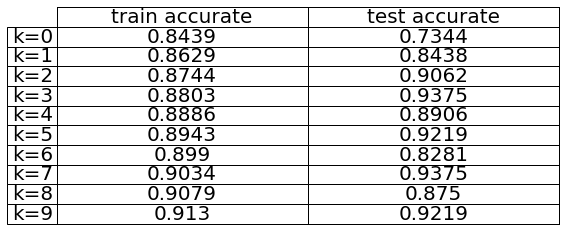

In [12]:
paint_table(train_accurate_arr, test_accurate_arr)